In [1]:

# Standard library imports
import os
import random
import gc
import configparser
import pickle
import copy
import tarfile
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import SwinForImageClassification, AutoImageProcessor, AutoModel, AutoModelForImageClassification
from transformers import AdamW
import torch.nn.functional as F

from torch.optim.lr_scheduler import OneCycleLR

# from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score


from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm

Environment Check

In [2]:
seed = 42

torch.manual_seed(seed)

np.random.seed(seed)

random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
import os
import pandas as pd

# Paths
image_folder = r"C:\Users\Downloads\train_images"  # Folder containing images
csv_path = r"C:\Users\Downloads\train.csv"  # CSV file path
output_csv = r"C:\Users\Downloads\matched_train.csv"  # Output CSV file

# Load CSV file
df = pd.read_csv(csv_path)

# Ensure image_id column matches extracted filenames
df["image_id"] = df["image_id"].astype(str)  # Convert to string for matching

# List available image files (only filenames without extension for matching)
available_images = {os.path.splitext(f)[0] for f in os.listdir(image_folder)}

# Filter DataFrame to only include images that exist in the folder
matched_df = df[df["image_id"].isin(available_images)]

# Save matched results
matched_df.to_csv(output_csv, index=False)

print(f"Matched dataset saved to {output_csv}")
print(f"Total Matched Images: {len(matched_df)}")


In [ ]:
import pandas as pd

csv_path = r"C:\Users\Downloads\train.csv"
df = pd.read_csv(csv_path)

print(f"Total rows in train.csv: {len(df)}")
print(f"Unique image IDs in train.csv: {df['image_id'].nunique()}")
import os

image_folder = r"C:\Users\Downloads\train_images"
image_files = os.listdir(image_folder)

print(f"Total images in folder: {len(image_files)}")
df["image_id"] = df["image_id"].astype(str) + ".png"  # Ensure .png extension
csv_images = set(df["image_id"])
folder_images = set(os.listdir(image_folder))

# Find missing images
missing_from_folder = csv_images - folder_images
missing_from_csv = folder_images - csv_images

print(f"Images in CSV but not in folder: {len(missing_from_folder)}")
print(f"Images in folder but not in CSV: {len(missing_from_csv)}")


In [ ]:
import pandas as pd

csv_path = r"C:\Users\Downloads\train.csv"
df = pd.read_csv(csv_path)

# Count duplicate image IDs
duplicate_counts = df["image_id"].value_counts()
duplicates = duplicate_counts[duplicate_counts > 1]

print(f"Total duplicate entries: {duplicates.sum()}")
print(f"Number of unique images with duplicates: {len(duplicates)}")
df = df.drop_duplicates(subset="image_id")  # Keep only one entry per image
clean_csv_path = r"C:\Users\Downloads\cleaned_train.csv"
df.to_csv(clean_csv_path, index=False)
print(f"Cleaned CSV saved to {clean_csv_path}")


In [ ]:
import pandas as pd

csv_path = r"C:\Users\Downloads\cleaned_train.csv"
df = pd.read_csv(csv_path)

print("CSV Columns:", df.columns.tolist())  # Print all column names
print("First few rows:\n", df.head())  # Show first few rows


CSV Columns: ['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
First few rows:
                            image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  
0     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
4     NaN     NaN     NaN     NaN  


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths
IMAGE_FOLDER = r"C:\Users\Downloads\train_images"  # Image folder
LABEL_CSV = r"C:\Users\Downloads\cleaned_train.csv"  # Cleaned CSV

# Load CSV
df = pd.read_csv(LABEL_CSV)

# Use 'class_id' as the label for stratification
label_column = "class_id"
if label_column not in df.columns:
    raise ValueError(f"❌ Column '{label_column}' not found in CSV! Available columns: {df.columns.tolist()}")

print(f"✅ Using '{label_column}' as label column")

# Drop any NaN labels
df = df.dropna(subset=[label_column])

# Split into Train (80%), Test (10%), Validation (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[label_column])
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[label_column])

# Save split datasets
train_csv_path = r"C:\Users\Downloads\train_labels.csv"
test_csv_path = r"C:\Users\Downloads\test_labels.csv"
val_csv_path = r"C:\Users\Downloads\val_labels.csv"

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)

print(f"✅ Train labels saved to {train_csv_path} ({len(train_df)} samples)")
print(f"✅ Test labels saved to {test_csv_path} ({len(test_df)} samples)")
print(f"✅ Validation labels saved to {val_csv_path} ({len(val_df)} samples)")


In [8]:
# Load the newly split datasets
train_labels_df = pd.read_csv(train_csv_path)
test_labels_df = pd.read_csv(test_csv_path)
val_labels_df = pd.read_csv(val_csv_path)

# Function to check for data leakage
def check_for_leakage(df1, df2, column="image_id"):
    """
    Check if there is any data leakage between two datasets based on a unique identifier.
    """
    df1_unique = set(df1[column].values)
    df2_unique = set(df2[column].values)
    return len(df1_unique.intersection(df2_unique)) > 0

# Check for data leakage between splits
leakage_train_val = check_for_leakage(train_labels_df, val_labels_df, "image_id")
leakage_train_test = check_for_leakage(train_labels_df, test_labels_df, "image_id")
leakage_val_test = check_for_leakage(val_labels_df, test_labels_df, "image_id")

print(f"🔍 Train-Val Leakage: {leakage_train_val}")
print(f"🔍 Train-Test Leakage: {leakage_train_test}")
print(f"🔍 Val-Test Leakage: {leakage_val_test}")

# Ensure bounding box values are numeric (convert and fill NaNs)
bbox_cols = ["x_min", "y_min", "x_max", "y_max"]
for df in [train_labels_df, test_labels_df, val_labels_df]:
    df[bbox_cols] = df[bbox_cols].apply(pd.to_numeric, errors='coerce')
    df[bbox_cols] = df[bbox_cols].fillna(0)  # Replace NaNs with 0

print("✅ Data Cleaning Completed!")


🔍 Train-Val Leakage: False
🔍 Train-Test Leakage: False
🔍 Val-Test Leakage: False
✅ Data Cleaning Completed!


In [9]:
# Function to check for data leakage
def check_for_leakage(df1, df2, column="image_id"):
    """
    Checks if there is any data leakage between two datasets based on a unique identifier (e.g., image_id).
    Returns True if there is leakage, otherwise False.
    """
    df1_unique = set(df1[column].values)
    df2_unique = set(df2[column].values)
    
    leaked_samples = df1_unique.intersection(df2_unique)
    
    if leaked_samples:
        print(f"⚠️ WARNING: {len(leaked_samples)} leaked samples found!")
    
    return len(leaked_samples) > 0

# Check for data leakage between Train, Validation, and Test sets
leakage_train_val = check_for_leakage(train_labels_df, val_labels_df, "image_id")
leakage_train_test = check_for_leakage(train_labels_df, test_labels_df, "image_id")
leakage_val_test = check_for_leakage(val_labels_df, test_labels_df, "image_id")

# Print results
print(f"🔍 Train-Val Leakage: {leakage_train_val}")
print(f"🔍 Train-Test Leakage: {leakage_train_test}")
print(f"🔍 Val-Test Leakage: {leakage_val_test}")


🔍 Train-Val Leakage: False
🔍 Train-Test Leakage: False
🔍 Val-Test Leakage: False


### Data Preparation

**Data Leakage**

In [10]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoImageProcessor

class MedDataset(Dataset):
    def __init__(self, data_dir, labels_df, image_processor, transforms=None):
        """
        Custom Dataset class for medical images.

        Args:
            data_dir (str): Path to the directory containing images.
            labels_df (pd.DataFrame): DataFrame containing image file names and corresponding labels.
            image_processor (AutoImageProcessor): Transformer image processor for preprocessing.
            transforms (callable, optional): Optional transformations to apply on images.
        """
        self.data_dir = data_dir
        self.labels_df = labels_df
        self.image_processor = image_processor
        self.transforms = transforms
    
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, index):
        # Get the image name and corresponding labels
        image_name = self.labels_df.iloc[index]["image_id"]  # Adjusted to match your column name
        labels = self.labels_df.iloc[index, 1:].values.astype(float)  # Exclude 'image_id' column
        
        # Construct the image path
        image_path = os.path.join(self.data_dir, image_name)
        
        # Open the image and convert to RGB
        image = Image.open(image_path).convert("RGB")
        
        # Apply preprocessing using the transformer image processor
        processed_image = self.image_processor(image, return_tensors="pt")
        image_tensor = processed_image["pixel_values"].squeeze(0)

        # Apply additional transformations if specified
        if self.transforms:
            image_tensor = self.transforms(image_tensor)
        
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        return image_tensor, labels_tensor


In [11]:
checkpoint_name = "microsoft/swin-tiny-patch4-window7-224"

In [12]:
swin_image_processor = AutoImageProcessor.from_pretrained(checkpoint_name)
swin_model = AutoModelForImageClassification.from_pretrained(checkpoint_name)

In [13]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [14]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [ ]:


# Define dataset directories (update these with actual paths)
TRAIN_DATASET = r"C:\Users\Downloads\train_images"
VAL_DATASET = r"C:\Users\Downloads\train_images"  # Assuming the same folder for validation
TEST_DATASET = r"C:\Users\Downloads\train_images"  # Assuming the same folder for test

# Load labels from your saved CSV files
train_labels_raw_df = pd.read_csv(r"C:\Users\Downloads\train_labels.csv")
val_labels_raw_df = pd.read_csv(r"C:\Users\Downloads\val_labels.csv")
test_labels_raw_df = pd.read_csv(r"C:\Users\\Downloads\test_labels.csv")

# Initialize datasets
train_dataset = MedDataset(
    data_dir=TRAIN_DATASET,
    labels_df=train_labels_raw_df,
    image_processor=swin_image_processor
)

val_dataset = MedDataset(
    data_dir=VAL_DATASET,
    labels_df=val_labels_raw_df,
    image_processor=swin_image_processor
)

test_dataset = MedDataset(
    data_dir=TEST_DATASET,
    labels_df=test_labels_raw_df,
    image_processor=swin_image_processor
)

# Define data loader parameters
batch_size = 128
num_workers = 4

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("✅ DataLoaders initialized successfully!")


✅ DataLoaders initialized successfully!


## Model

In [16]:
swin_image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [17]:
custom_processor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [18]:
model_config = swin_model.config

In [19]:
model_config.hidden_size

768

In [20]:
model_config.hidden_act

'gelu'

In [21]:
swin_model.classifier

Linear(in_features=768, out_features=1000, bias=True)

In [22]:
swin_model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [23]:
swin_model.swin.encoder.layers

ModuleList(
  (0): SwinStage(
    (blocks): ModuleList(
      (0-1): 2 x SwinLayer(
        (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attention): SwinAttention(
          (self): SwinSelfAttention(
            (query): Linear(in_features=96, out_features=96, bias=True)
            (key): Linear(in_features=96, out_features=96, bias=True)
            (value): Linear(in_features=96, out_features=96, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): SwinSelfOutput(
            (dense): Linear(in_features=96, out_features=96, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (drop_path): SwinDropPath(p=0.1)
        (layernorm_after): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (intermediate): SwinIntermediate(
          (dense): Linear(in_features=96, out_features=384, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
      

In [24]:
len(swin_model.swin.encoder.layers)

4

* Stage 0: The first stage has 2 blocks with 96 features. This stage is responsible for processing lower-level information such as edges and textures.
* Stage 1: The second stage has 2 blocks with 192 features. This stage processes more complex features, combining the initial low-level information.
* Stage 2: The third stage has 6 blocks with 384 features. At this point, the model captures more semantic information and high-level patterns.
* Stage 3: The fourth stage has 2 blocks with 768 features. This stage is responsible for the most abstract features and task-specific learning.

In [25]:
import torch
import torch.nn as nn
from transformers import AutoModelForImageClassification

# Configuration Variables
PRETRAINED_MODEL_NAME = "microsoft/swin-tiny-patch4-window7-224"
NUM_CLASSES = 14
HIDDEN_DIM = 512
LORA_R = 8
LORA_ALPHA = 32
LORA_DROPOUT = 0.1
UNFREEZE_LAYERS = 2  # Number of layers to unfreeze

# Model Configuration
swin_model = AutoModelForImageClassification.from_pretrained(PRETRAINED_MODEL_NAME)
model_config = swin_model.config
hidden_size = model_config.hidden_size
hidden_act = model_config.hidden_act

print(f"Model Hidden Size: {hidden_size}")
print(f"Activation Function: {hidden_act}")

# Swin Model Details
print(f"Classifier: {swin_model.classifier}")
print(f"Encoder Layers: {len(swin_model.swin.encoder.layers)}")


class SwinModelWithPEFT(nn.Module):
    """
    Swin Transformer Model with optional Parameter-Efficient Fine-Tuning (PEFT).
    """

    def __init__(
        self,
        pretrained_model_name=PRETRAINED_MODEL_NAME,
        lora_r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        unfreeze_layers=UNFREEZE_LAYERS,
    ):
        super(SwinModelWithPEFT, self).__init__()

        # Load Pretrained Swin Model
        self.backbone = AutoModelForImageClassification.from_pretrained(pretrained_model_name)
        self.backbone.classifier = nn.Identity()  # Remove classifier for feature extraction

        # LoRA - Skipped due to time constraints, but left for reference
        """
        lora_config = LoraConfig(
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
            target_modules=["query", "value"],
            task_type="FEATURE_EXTRACTION"
        )
        self.backbone = get_peft_model(self.backbone, lora_config)
        """

        # Unfreeze selected layers
        self._unfreeze_layers(unfreeze_layers)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        return outputs

    def _unfreeze_layers(self, num_layers_to_unfreeze):
        """
        Unfreeze the last `num_layers_to_unfreeze` layers of the Swin model.
        """
        stages = self.backbone.swin.encoder.layers
        total_stages = len(stages)

        for i, stage in enumerate(stages):
            if i < total_stages - num_layers_to_unfreeze:
                for param in stage.parameters():
                    param.requires_grad = False
            else:
                for block in stage.blocks:
                    for param in block.parameters():
                        param.requires_grad = True

    def freeze_all_layers(self):
        """Freeze all layers of the backbone model."""
        for param in self.backbone.parameters():
            param.requires_grad = False

    def unfreeze_all_layers(self):
        """Unfreeze all layers of the backbone model."""
        for param in self.backbone.parameters():
            param.requires_grad = True


class MultiLabelClassifier(nn.Module):
    """
    Fully connected classifier for multi-label classification.
    """

    def __init__(self, feature_dim, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES):
        super(MultiLabelClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, features):
        return self.classifier(features)


class MultiLabelModel(nn.Module):
    """
    Full model combining feature extraction and multi-label classification.
    """

    def __init__(
        self,
        pretrained_model_name=PRETRAINED_MODEL_NAME,
        num_classes=NUM_CLASSES,
        hidden_dim=HIDDEN_DIM,
        lora_r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
    ):
        super(MultiLabelModel, self).__init__()

        # Feature Extractor (Swin Model with optional PEFT)
        self.feature_extractor = SwinModelWithPEFT(
            pretrained_model_name=pretrained_model_name,
            lora_r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
        )

        feature_dim = self.feature_extractor.backbone.config.hidden_size

        # Classifier Head
        self.classifier = MultiLabelClassifier(
            feature_dim=feature_dim,
            hidden_dim=hidden_dim,
            num_classes=num_classes,
        )

    def forward(self, pixel_values):
        outputs = self.feature_extractor(pixel_values=pixel_values)
        features = outputs.logits  # Extract features
        logits = self.classifier(features)
        return logits


# Initialize the model
model = MultiLabelModel()
print("✅ Model initialized successfully!")


Model Hidden Size: 768
Activation Function: gelu
Classifier: Linear(in_features=768, out_features=1000, bias=True)
Encoder Layers: 4
✅ Model initialized successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display column names
print("Columns in dataset:", train_labels_raw_df.columns.tolist())

# Print distribution for each label
for column in train_labels_raw_df.columns[1:]:
    print(f"\nDistribution of {column}:")
    print(train_labels_raw_df[column].value_counts())

# Plot distributions
plt.figure(figsize=(12, 8))
for i, column in enumerate(train_labels_raw_df.columns[1:]):
    plt.subplot(4, 4, i + 1)
    sns.countplot(x=column, data=train_labels_raw_df, palette="coolwarm")
    plt.title(f"Distribution of {column}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Ensure all label columns are numeric
train_labels_raw_df.iloc[:, 1:] = train_labels_raw_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Total number of samples
total_samples = len(train_labels_raw_df)

# Count number of positive samples per class
positive_counts = train_labels_raw_df.iloc[:, 1:].sum(axis=0)

# Avoid division by zero: Replace zero counts with a small value
positive_counts = positive_counts.replace(0, 1e-6)

# Compute class weights using inverse frequency method
class_weights = total_samples / positive_counts

# Normalize weights (divide by max weight to keep scale reasonable)
normalized_class_weights = class_weights / class_weights.max()

# Print computed class weights
print("\nComputed Class Weights:\n", normalized_class_weights)

# Verify normalization
sum_normalized = normalized_class_weights.sum()
sum_original = class_weights.sum()
print(f"Normalized Sum: {sum_normalized}, Original Sum: {sum_original}")


In [ ]:
print("Positive Counts per Class:\n", positive_counts)
positive_counts = positive_counts.replace(0, 1e-6)
import pandas as pd

# Ensure all label columns are numeric
train_labels_raw_df.iloc[:, 1:] = train_labels_raw_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Total number of samples
total_samples = len(train_labels_raw_df)

# Count number of positive samples per class
positive_counts = train_labels_raw_df.iloc[:, 1:].sum(axis=0)

# Debugging: Print positive_counts to check for zeros
print("Positive Counts per Class:\n", positive_counts)

# Avoid division by zero: Replace zero counts with a small value
positive_counts = positive_counts.replace(0, 1e-6)

# Compute class weights using inverse frequency method
class_weights = total_samples / positive_counts

# Normalize weights (divide by max weight to keep scale reasonable)
normalized_class_weights = class_weights / class_weights.max()

# Print computed class weights
print("\nComputed Class Weights:\n", normalized_class_weights)

# Verify normalization
sum_normalized = normalized_class_weights.sum()
sum_original = class_weights.sum()
print(f"Normalized Sum: {sum_normalized}, Original Sum: {sum_original}")


In [ ]:
import pandas as pd

# Convert all columns except the first (ID column) to numeric
train_labels_raw_df.iloc[:, 1:] = train_labels_raw_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Select only class label columns (excluding 'class_name', 'rad_id', and any coordinate columns)
class_label_columns = [col for col in train_labels_raw_df.columns if 'class' in col.lower()]
train_labels_cleaned = train_labels_raw_df[class_label_columns]

# Total number of samples
total_samples = len(train_labels_cleaned)

# Count number of positive samples per class
positive_counts = train_labels_cleaned.sum(axis=0)

# Debugging: Print positive_counts to check for zeros
print("Filtered Positive Counts per Class:\n", positive_counts)

# Avoid division by zero: Replace zero counts with a small value
positive_counts = positive_counts.replace(0, 1e-6)

# Compute class weights using inverse frequency method
class_weights = total_samples / positive_counts

# Normalize weights (divide by max weight to keep scale reasonable)
normalized_class_weights = class_weights / class_weights.max()

# Print computed class weights
print("\nComputed Class Weights:\n", normalized_class_weights)


In [ ]:
# Create a DataFrame for visualization
class_counts = train_labels_raw_df.iloc[:, 1:].sum()
class_dist_df = pd.DataFrame({'Class': class_counts.index, 'Count': class_counts.values})
class_dist_df = class_dist_df.sort_values(by='Count', ascending=False)

# Print class distribution
print("\nOverall Sample Distribution:")
print(class_dist_df)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(x='Class', y='Count', data=class_dist_df, palette="viridis")
plt.title("Overall Sample Distribution of Classes", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Positive Samples", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()


## Loss calculation

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModifiedWeightedFocalLoss(nn.Module):
    def __init__(self, class_weights=None, gamma=2.0, alpha=0.25, reduction="mean"):
        """
        Implements Focal Loss with optional class weighting.
        - gamma: Focal Loss focusing parameter
        - alpha: Balances positive vs negative samples
        - class_weights: Precomputed class-wise weights for handling imbalance
        """
        super(ModifiedWeightedFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

        # Convert class weights to tensor if provided
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        else:
            self.class_weights = torch.ones(14)  # Default to equal weighting

    def forward(self, inputs, targets):
        """
        Computes the focal loss.
        - inputs: Model predictions (logits)
        - targets: True labels (binary)
        """
        # Apply sigmoid activation
        probas = torch.sigmoid(inputs)

        # Compute Binary Cross Entropy (BCE) loss
        bce_loss = F.binary_cross_entropy(probas, targets, reduction="none")

        # Compute modulating factor: (1 - p_t)^gamma
        p_t = probas * targets + (1 - probas) * (1 - targets)
        modulating_factor = (1 - p_t) ** self.gamma

        # Compute final weighted focal loss
        focal_loss = self.alpha * modulating_factor * bce_loss

        # Apply class weights
        weighted_loss = focal_loss * self.class_weights.to(inputs.device)

        # Compute final loss reduction
        if self.reduction == "mean":
            return weighted_loss.mean()
        elif self.reduction == "sum":
            return weighted_loss.sum()
        else:
            return weighted_loss


In [32]:
# Sum of normalized weights vs. original weights
sum_normalized = normalized_class_weights.values.sum()
sum_original = class_weights.values.sum()

print(f"\nSum of Normalized Weights: {sum_normalized}")
print(f"Sum of Original Weights: {sum_original}")

# Ratio between normalized and original
weight_ratio = sum_normalized / sum_original
print(f"Ratio of Normalized to Original Weights: {weight_ratio:.4f}")



Sum of Normalized Weights: 1.0000000000072113
Sum of Original Weights: 12000000000.086536
Ratio of Normalized to Original Weights: 0.0000


In [33]:
# Identify only numeric class labels (exclude non-numeric columns like 'class_name')
class_label_columns = train_labels_raw_df.select_dtypes(include=['number']).columns.tolist()

# Ensure we're not keeping unwanted columns like IDs
exclude_columns = ['class_name', 'rad_id']  # Add more if needed
class_label_columns = [col for col in class_label_columns if col not in exclude_columns]

# Use only relevant class labels
train_labels_cleaned = train_labels_raw_df[class_label_columns]

# Debug: Print the selected columns
print("Selected Class Label Columns:", class_label_columns)

# Compute positive sample counts per class
positive_counts = train_labels_cleaned.sum(axis=0)

# Avoid division by zero
positive_counts = positive_counts.replace(0, 1e-6)

# Compute class weights
class_weights = len(train_labels_cleaned) / positive_counts

# Normalize class weights
normalized_class_weights = class_weights / class_weights.max()

# Print computed class weights
print("\nComputed Class Weights:\n", normalized_class_weights)


Selected Class Label Columns: ['class_id', 'x_min', 'y_min', 'x_max', 'y_max']

Computed Class Weights:
 class_id    1.000000
x_min       0.037184
y_min       0.038043
x_max       0.025615
y_max       0.027742
dtype: float64


In [34]:
train_labels_raw_df.iloc[0, 1:]

class_name    NaN
class_id       14
rad_id        NaN
x_min         NaN
y_min         NaN
x_max         NaN
y_max         NaN
Name: 0, dtype: object


Overall Sample Distribution:
        Class      Count
5       x_max  5413559.0
6       y_max  4998487.0
3       x_min  3729301.0
4       y_min  3645029.0
1    class_id     138669
0  class_name          0
2      rad_id          0


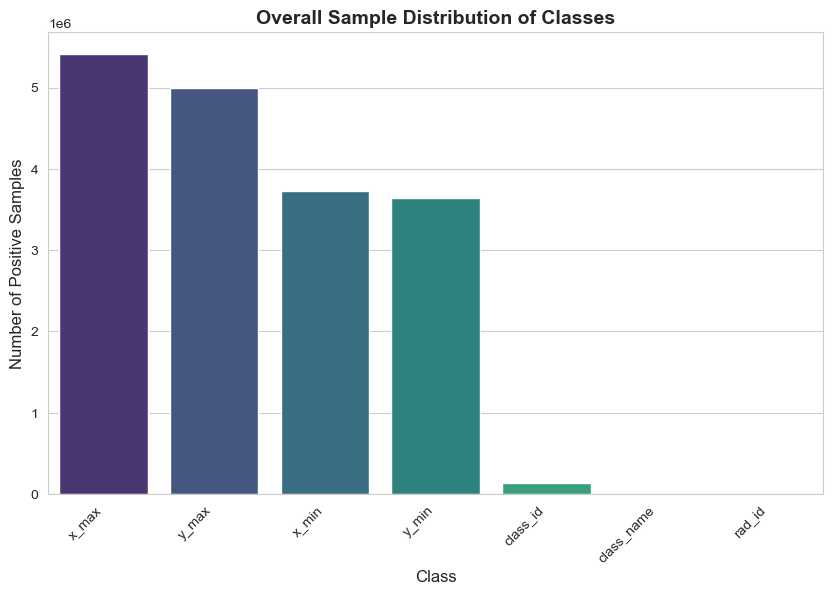

In [35]:
class_counts = train_labels_raw_df.iloc[:, 1:].sum()

class_dist_df = pd.DataFrame({'Class': class_counts.index, 'Count': class_counts.values})
class_dist_df = class_dist_df.sort_values(by='Count', ascending=False)

print("\nOverall Sample Distribution:")
print(class_dist_df)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(x='Class', y='Count', data=class_dist_df, palette="viridis", hue='Class')
plt.title("Overall Sample Distribution of Classes", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Positive Samples", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()


In [36]:
class ModifiedWeightedFocalLoss(nn.Module):
    def __init__(self, class_weights=None, gamma=2.0, alpha=0.25, reduction="mean"):
        super(ModifiedWeightedFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        
        if class_weights is not None:
            self.class_weights = class_weights
        else:
            self.class_weights = torch.ones(14)

    def forward(self, inputs, targets):

        probas = torch.sigmoid(inputs)

        bce_loss = F.binary_cross_entropy(probas, targets, reduction="none")
        
        # modulating factor (1 - p_t) ** gamma
        p_t = probas * targets + (1 - probas) * (1 - targets)
        modulating_factor = (1 - p_t) ** self.gamma
        
        # focal loss term
        focal_loss = self.alpha * modulating_factor * bce_loss

        weighted_loss = focal_loss * self.class_weights

        # final loss
        if self.reduction == "mean":
            return weighted_loss.mean()
        elif self.reduction == "sum":
            return weighted_loss.sum()
        else:
            return weighted_loss


In [37]:
class_counts

class_name            0
class_id         138669
rad_id                0
x_min         3729301.0
y_min         3645029.0
x_max         5413559.0
y_max         4998487.0
dtype: object

In [38]:
import pandas as pd
import torch

# Ensure all label columns are numeric
train_labels_raw_df.iloc[:, 1:] = train_labels_raw_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Exclude non-class columns (metadata)
exclude_columns = ['image_id', 'x_min', 'y_min', 'x_max', 'y_max']  
class_label_columns = [col for col in train_labels_raw_df.columns if col not in exclude_columns]
train_labels_cleaned = train_labels_raw_df[class_label_columns]

# Convert all values to numeric and fill NaNs with 0
train_labels_cleaned = train_labels_cleaned.apply(pd.to_numeric, errors='coerce').fillna(0)

# Compute positive sample counts per class
total_samples = len(train_labels_cleaned)
positive_counts = train_labels_cleaned.sum(axis=0)

# Ensure no zero values in denominators to avoid division errors
positive_counts = positive_counts.replace(0, 1e-6)

# Compute and normalize class weights
class_weights = total_samples / positive_counts
normalized_class_weights = class_weights / class_weights.max()

# Debugging: Print computed class weights
print("\nComputed Class Weights:\n", normalized_class_weights)
print(f"Sum of Normalized Weights: {normalized_class_weights.sum()}")
print(f"Sum of Original Weights: {class_weights.sum()}")
print(f"Ratio of Normalized to Original Weights: {normalized_class_weights.sum() / class_weights.sum():.4f}")

# Convert to PyTorch tensor
weights = torch.tensor(normalized_class_weights.values, dtype=torch.float32)



Computed Class Weights:
 class_name    1.000000e+00
class_id      7.211417e-12
rad_id        1.000000e+00
dtype: float64
Sum of Normalized Weights: 2.000000000007211
Sum of Original Weights: 24000000000.086536
Ratio of Normalized to Original Weights: 0.0000


In [ ]:
# Create a DataFrame for visualization
class_counts = train_labels_cleaned.sum()
class_dist_df = pd.DataFrame({'Class': class_counts.index, 'Count': class_counts.values})
class_dist_df = class_dist_df.sort_values(by='Count', ascending=False)

# Print and visualize class distribution
print("\nOverall Sample Distribution:")
print(class_dist_df)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(x='Class', y='Count', data=class_dist_df, palette="viridis")
plt.title("Overall Sample Distribution of Classes", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Positive Samples", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()


In [40]:
class ModifiedWeightedFocalLoss(nn.Module):
    def __init__(self, class_weights=None, gamma=2.0, alpha=0.25, reduction="mean"):
        super(ModifiedWeightedFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.class_weights = class_weights if class_weights is not None else torch.ones(len(class_weights))

    def forward(self, inputs, targets):
        probas = torch.sigmoid(inputs)
        bce_loss = F.binary_cross_entropy(probas, targets, reduction="none")

        # Compute modulating factor (1 - p_t)^gamma
        p_t = probas * targets + (1 - probas) * (1 - targets)
        modulating_factor = (1 - p_t) ** self.gamma

        # Compute final focal loss
        focal_loss = self.alpha * modulating_factor * bce_loss
        weighted_loss = focal_loss * self.class_weights.to(inputs.device)

        return weighted_loss.mean() if self.reduction == "mean" else weighted_loss.sum()


In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_loader), epochs=50)

# Define loss function with computed weights
criterion = ModifiedWeightedFocalLoss(class_weights=weights, gamma=2.0, alpha=0.25, reduction="mean")

# Sample image processing
image_path = r"C:\Users\Documents\cdac\Extracted_DATASET\train\00000008_001.png"
image = Image.open(image_path).convert("RGB")
processed_image = swin_image_processor(image, return_tensors="pt")

# Extract model components
pixel_values = processed_image["pixel_values"]
model_feature_extractor = model.feature_extractor
model_classifier = model.classifier


In [42]:
print(train_labels_df.columns)
print([col for col in train_labels_df.columns if "atelectasis" in col.lower()])
print(train_labels_df.head())
print(train_labels_df.info())
train_labels_df.rename(columns=lambda x: x.strip(), inplace=True)
print(train_labels_df.isna().sum())


Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max'],
      dtype='object')
[]
                           image_id  class_name  class_id rad_id  x_min  \
0  4d4bffa2926bfcb4851b5e968136b047  No finding        14    R12    0.0   
1  252353e9dd191831175accddf57e9625  No finding        14     R9    0.0   
2  328e89c3bad7c078d2295a666e496bc7  No finding        14    R16    0.0   
3  139282fc433f147aba91c6a99b8376c3  No finding        14     R8    0.0   
4  d558c4e784e7c5808e1226f1f0f3559b  No finding        14     R1    0.0   

   y_min  x_max  y_max  
0    0.0    0.0    0.0  
1    0.0    0.0    0.0  
2    0.0    0.0    0.0  
3    0.0    0.0    0.0  
4    0.0    0.0    0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    12000 non-null  object 
 1   class_name  12000 non-null  object 
 2 

In [ ]:
train_labels_df["Atelectasis"] = train_labels_df["class_name_Atelectasis"]
atelectasis_col = [col for col in train_labels_df.columns if "Atelectasis" in col]
if atelectasis_col:
    train_labels_df["Atelectasis"] = train_labels_df[atelectasis_col[0]]


In [ ]:
def get_data_loaders(self, fold):
    atelectasis_col = [col for col in self.train_labels_df.columns if "Atelectasis" in col]
    if not atelectasis_col:
        raise ValueError("No 'Atelectasis' column found in train_labels_df. Check column names.")

    train_idx, val_idx = list(self.kfold.split(self.train_labels_df, self.train_labels_df[atelectasis_col[0]]))[fold]
    train_subset = Subset(self.train_dataset, train_idx)
    val_subset = Subset(self.train_dataset, val_idx)
    return DataLoader(train_subset, batch_size=self.batch_size, shuffle=self.shuffle), DataLoader(val_subset, batch_size=self.batch_size, shuffle=False)
print(train_labels_df.columns)
atelectasis_col = [col for col in self.train_labels_df.columns if "Atelectasis" in col]
if not atelectasis_col:
    raise ValueError("No 'Atelectasis' column found in train_labels_df. Check column names.")
train_idx, val_idx = list(self.kfold.split(self.train_labels_df, self.train_labels_df[atelectasis_col[0]]))[fold]
print(train_labels_df.head())  # Inspect first few rows
print(train_labels_df.columns) # Check column names
train_labels_df = pd.get_dummies(train_labels_df, columns=["class_name"])
train_labels_df["Atelectasis"] = train_labels_df["class_name_Atelectasis"]


Index(['image_id', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max',
       'class_name_Aortic enlargement', 'class_name_Atelectasis',
       'class_name_Calcification', 'class_name_Cardiomegaly',
       'class_name_Consolidation', 'class_name_ILD', 'class_name_Infiltration',
       'class_name_Lung Opacity', 'class_name_No finding',
       'class_name_Nodule/Mass', 'class_name_Other lesion',
       'class_name_Pleural effusion', 'class_name_Pleural thickening',
       'class_name_Pneumothorax', 'class_name_Pulmonary fibrosis',
       'Atelectasis'],
      dtype='object')


NameError: name 'self' is not defined

In [ ]:
class StratifiedKFoldCV:
    def __init__(self, train_dataset, train_labels_df, val_dataset=None, val_labels_df=None,
                 k_folds=5, batch_size=32, shuffle=True, random_seed=42, log_dir="runs/stratified_kfold"):
        self.train_dataset = train_dataset
        self.train_labels_df = train_labels_df
        self.val_dataset = val_dataset
        self.val_labels_df = val_labels_df
        self.k_folds = k_folds
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_seed = random_seed
        self.log_dir = log_dir
        self.kfold = StratifiedKFold(n_splits=k_folds, shuffle=shuffle, random_state=random_seed)
        self.writer = SummaryWriter(log_dir)
        self.save_dir = "model_weights"

    def get_data_loaders(self, fold):
        train_idx, val_idx = list(self.kfold.split(self.train_labels_df, self.train_labels_df['Atelectasis']))[fold]
        train_subset = Subset(self.train_dataset, train_idx)
        val_subset = Subset(self.train_dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=self.shuffle)
        val_loader = DataLoader(val_subset, batch_size=self.batch_size, shuffle=False)
        return train_loader, val_loader

    def train(self, model, optimizer, scheduler, criterion, device, train_loader, epoch):
        model.train()
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0
        all_train_labels = []
        all_train_preds = []

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            running_train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct_train_predictions += (predictions == labels).sum().item()
            total_train_samples += labels.numel()
            all_train_labels.append(labels.cpu().numpy())
            all_train_preds.append(predictions.cpu().numpy())

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_samples * 100
        all_train_labels = np.concatenate(all_train_labels)
        all_train_preds = np.concatenate(all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
        return avg_train_loss, train_accuracy, train_f1

    def validate(self, model, criterion, device, val_loader, epoch):
        model.eval()
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                correct_val_predictions += (predictions == labels).sum().item()
                total_val_samples += labels.numel()
                all_val_labels.append(labels.cpu().numpy())
                all_val_preds.append(predictions.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val_predictions / total_val_samples * 100
        all_val_labels = np.concatenate(all_val_labels)
        all_val_preds = np.concatenate(all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
        return avg_val_loss, val_accuracy, val_f1

    def run(self, model, optimizer, scheduler, criterion, device, num_epochs=25):
        fold_train_losses = []
        fold_val_losses = []
        fold_val_accuracies = []
        fold_val_f1_scores = []

        for fold in range(self.k_folds):
            train_loader, val_loader = self.get_data_loaders(fold)
            for epoch in range(num_epochs):
                avg_train_loss, train_accuracy, train_f1 = self.train(
                    model, optimizer, scheduler, criterion, device, train_loader, epoch
                )
                avg_val_loss, val_accuracy, val_f1 = self.validate(
                    model, criterion, device, val_loader, epoch
                )
                self.writer.add_scalars('Loss', {'train': avg_train_loss, 'val': avg_val_loss}, epoch)
                self.writer.add_scalars('Accuracy', {'train': train_accuracy, 'val': val_accuracy}, epoch)
                self.writer.add_scalars('F1 Score', {'train': train_f1, 'val': val_f1}, epoch)

            fold_train_losses.append(avg_train_loss)
            fold_val_losses.append(avg_val_loss)
            fold_val_accuracies.append(val_accuracy)
            fold_val_f1_scores.append(val_f1)
            torch.save(model.state_dict(), self.save_dir + f"_fold{fold}")

        avg_train_loss = sum(fold_train_losses) / len(fold_train_losses)
        avg_val_loss = sum(fold_val_losses) / len(fold_val_losses)
        avg_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)
        avg_val_f1 = sum(fold_val_f1_scores) / len(fold_val_f1_scores)
        return avg_train_loss, avg_val_loss, avg_val_accuracy, avg_val_f1

stratified_kfold = StratifiedKFoldCV(
    train_dataset=train_dataset,
    train_labels_df=train_labels_raw_df,
    val_dataset=val_dataset,
    val_labels_df=val_labels_raw_df,
    k_folds=5
)

avg_train_loss, avg_val_loss, avg_val_accuracy = stratified_kfold.run(model, optimizer, scheduler, criterion, device)


In [ ]:
total_samples = len(train_labels_raw_df)

positive_counts = train_labels_raw_df.iloc[:, 1:].sum(axis=0)

class_weights = total_samples / positive_counts

normalized_class_weights = class_weights / class_weights.max()

In [51]:
normalized_class_weights.values

array([1.        , 0.03718364, 0.03804332, 0.02561513, 0.02774219])

In [41]:
normalized_class_weights.values.sum()

1.8668919412990093

In [42]:
class_weights.values.sum()

859.2573082865788

In [43]:
type(normalized_class_weights)

pandas.core.series.Series

In [44]:
weights = torch.tensor(normalized_class_weights.values)

In [45]:
weights

tensor([0.0217, 0.0829, 0.0187, 0.0123, 0.0481, 0.0396, 0.1565, 0.0482, 0.0519,
        0.0991, 0.0838, 0.1314, 0.0727, 1.0000], dtype=torch.float64)

## Train

### Param

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_loader), epochs=50)
criterion = ModifiedWeightedFocalLoss(class_weights=weights, gamma=2.0, alpha=0.25, reduction="mean")

In [47]:
sample_data = train_dataset[0]

In [48]:
type(sample_data)

tuple

In [ ]:
image_path = r"C:\Users\Documents\cdac\Extracted_DATASET\train\00000008_001.png"


In [50]:
image = Image.open(image_path).convert("RGB")
processed_image = swin_image_processor(image, return_tensors="pt")

In [51]:
processed_image.keys()

dict_keys(['pixel_values'])

In [52]:
processed_image["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [53]:
processed_image["pixel_values"].squeeze(0).shape

torch.Size([3, 224, 224])

In [54]:
swin_model.classifier

Linear(in_features=768, out_features=1000, bias=True)

In [55]:
model.classifier

MultiLabelClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=14, bias=True)
    (4): Sigmoid()
  )
)

In [56]:
pixel_values = processed_image["pixel_values"]

In [57]:
model_feature_extractor = model.feature_extractor
model_classifier = model.classifier

In [63]:
class StratifiedKFoldCV:
    def __init__(self, train_dataset, train_labels_df, val_dataset=None, val_labels_df=None, 
                 k_folds=5, batch_size=32, shuffle=True, random_seed=42, log_dir="runs/stratified_kfold"):
        """
        Args:
            train_dataset (Dataset): The training dataset (e.g., MedDataset) to be split into K folds.
            train_labels_df (DataFrame): The labels dataframe for the training dataset.
            val_dataset (Dataset, optional): The validation dataset for evaluating the model on fixed data.
            val_labels_df (DataFrame, optional): The labels dataframe for the validation dataset.
            k_folds (int): The number of folds for cross-validation.
            batch_size (int): Batch size for the DataLoader.
            shuffle (bool): Whether to shuffle the dataset before splitting.
            random_seed (int): Random seed for reproducibility.
            log_dir (str): Directory to store TensorBoard logs.
        """
        self.train_dataset = train_dataset
        self.train_labels_df = train_labels_df
        self.val_dataset = val_dataset
        self.val_labels_df = val_labels_df
        self.k_folds = k_folds
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_seed = random_seed
        self.log_dir = log_dir
        self.kfold = StratifiedKFold(n_splits=k_folds, shuffle=shuffle, random_state=random_seed)
        self.writer = SummaryWriter(log_dir)
        
        self.save_dir = "model_weights"
        

    def get_data_loaders(self, fold):
        """
        Get the train and validation DataLoaders for the current fold.

        Args:
            fold (int): The current fold number.

        Returns:
            train_loader (DataLoader): DataLoader for the training set of the current fold.
            val_loader (DataLoader): DataLoader for the validation set of the current fold.
        """
        # Get the indices for train and validation splits for the current fold
        train_idx, val_idx = list(self.kfold.split(self.train_labels_df, self.train_labels_df['Atelectasis']))[fold]

        # Create Subsets for training and validation sets
        train_subset = Subset(self.train_dataset, train_idx)
        val_subset = Subset(self.train_dataset, val_idx)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=self.shuffle)
        val_loader = DataLoader(val_subset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader

    def train(self, model, optimizer, scheduler, criterion, device, train_loader, epoch):
        """
        Train the model for one epoch.

        Args:
            model (nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): The optimizer.
            scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
            criterion (nn.Module): The loss function.
            device (torch.device): The device (GPU or CPU).
            train_loader (DataLoader): DataLoader for the training set.

        Returns:
            avg_train_loss (float): Average training loss for the epoch.
            train_accuracy (float): Training accuracy for the epoch.
            train_f1 (float): Training F1 score for the epoch.
        """
        model.train()
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0
        all_train_labels = []
        all_train_preds = []

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero out gradients from the previous step

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping (to avoid exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()

            # Update learning rate scheduler
            scheduler.step()

            # Accumulate loss for logging
            running_train_loss += loss.item()

            # For multi-label classification, use thresholding at 0.5 to predict class labels
            predictions = (outputs > 0.5).float()  # Sigmoid thresholding
            correct_train_predictions += (predictions == labels).sum().item()
            total_train_samples += labels.numel()

            # Collect all labels and predictions for F1 score
            all_train_labels.append(labels.cpu().numpy())
            all_train_preds.append(predictions.cpu().numpy())

        # Average training loss and accuracy
        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_samples * 100  # In percentage

        # Flatten lists for F1 calculation
        all_train_labels = np.concatenate(all_train_labels)
        all_train_preds = np.concatenate(all_train_preds)

        # F1 score
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

        print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}")

        return avg_train_loss, train_accuracy, train_f1

    def validate(self, model, criterion, device, val_loader, epoch):
        """
        Validate the model on the validation set.

        Args:
            model (nn.Module): The model to validate.
            criterion (nn.Module): The loss function.
            device (torch.device): The device (GPU or CPU).
            val_loader (DataLoader): DataLoader for the validation set.

        Returns:
            avg_val_loss (float): Average validation loss for the epoch.
            val_accuracy (float): Validation accuracy for the epoch.
            val_f1 (float): Validation F1 score for the epoch.
        """
        model.eval()
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in tqdm(val_loader, desc="Validating", leave=False):
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                running_val_loss += loss.item()

                # For multi-label classification, use thresholding at 0.5 to predict class labels
                predictions = (outputs > 0.5).float()  # Sigmoid thresholding
                correct_val_predictions += (predictions == labels).sum().item()
                total_val_samples += labels.numel()

                # Collect all labels and predictions for F1 score
                all_val_labels.append(labels.cpu().numpy())
                all_val_preds.append(predictions.cpu().numpy())

        # Average validation loss and accuracy
        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val_predictions / total_val_samples * 100  # In percentage

        # Flatten lists for F1 calculation
        all_val_labels = np.concatenate(all_val_labels)
        all_val_preds = np.concatenate(all_val_preds)

        # F1 score
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
        
        print(f"Epoch {epoch + 1} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val F1: {val_f1:.4f}")

        return avg_val_loss, val_accuracy, val_f1

    def plot_losses(self, train_losses, val_losses, epoch):
        """
        Plot the training and validation loss for the current epoch.

        Args:
            train_losses (list): List of training losses.
            val_losses (list): List of validation losses.
            epoch (int): Current epoch number.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label="Train Loss", color="blue")
        plt.plot(val_losses, label="Val Loss", color="red")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Losses for Epoch {epoch}")
        plt.legend()
        plt.savefig(f"epoch_{epoch}_loss_plot.png")
        plt.close()

    def run(self, model, optimizer, scheduler, criterion, device, num_epochs=25):
        """
        Run Stratified K-Fold Cross Validation.

        Args:
            model (nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): The optimizer.
            scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
            criterion (nn.Module): The loss function.
            device (torch.device): The device (GPU or CPU).
            num_epochs (int): Number of epochs for training.

        Returns:
            avg_train_loss (float): Average training loss across all folds.
            avg_val_loss (float): Average validation loss across all folds.
            avg_val_accuracy (float): Average validation accuracy across all folds.
        """
        fold_train_losses = []
        fold_val_losses = []
        fold_val_accuracies = []
        fold_val_f1_scores = []

        i = 0
        
        for fold in range(self.k_folds):
            print(f"Fold {fold + 1}/{self.k_folds}")
            train_loader, val_loader = self.get_data_loaders(fold)

            # Initialize loss lists for plotting
            train_losses = []
            val_losses = []

            for epoch in range(num_epochs):
                print(f"Epoch {epoch + 1}/{num_epochs}")

                # Train the model for the current epoch
                avg_train_loss, train_accuracy, train_f1 = self.train(
                    model, optimizer, scheduler, criterion, device, train_loader, epoch
                )

                # Validate the model for the current epoch
                avg_val_loss, val_accuracy, val_f1 = self.validate(
                    model, criterion, device, val_loader, epoch
                )

                # Log metrics to TensorBoard
                self.writer.add_scalars('Loss', {'train': avg_train_loss, 'val': avg_val_loss}, epoch)
                self.writer.add_scalars('Accuracy', {'train': train_accuracy, 'val': val_accuracy}, epoch)
                self.writer.add_scalars('F1 Score', {'train': train_f1, 'val': val_f1}, epoch)

                # Save losses for plotting
                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)

                # Plot losses every 10 epochs
                self.plot_losses(train_losses, val_losses, epoch + 1)

            fold_train_losses.append(avg_train_loss)
            fold_val_losses.append(avg_val_loss)
            fold_val_accuracies.append(val_accuracy)
            fold_val_f1_scores.append(val_f1)

            save_path = self.save_dir + f"_fold{i}"
            i += 1
            
            torch.save(model.state_dict(), save_path)
            
            print(f"Fold {fold + 1} - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
            print(f"Fold {fold + 1} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
            print(f"Fold {fold + 1} - Val F1: {val_f1:.4f}")

        # Calculate average metrics across all folds
        avg_train_loss = sum(fold_train_losses) / len(fold_train_losses)
        avg_val_loss = sum(fold_val_losses) / len(fold_val_losses)
        avg_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)
        avg_val_f1 = sum(fold_val_f1_scores) / len(fold_val_f1_scores)

        print(f"Average Train Loss: {avg_train_loss:.4f}")
        print(f"Average Val Loss: {avg_val_loss:.4f}")
        print(f"Average Val Accuracy: {avg_val_accuracy:.2f}%")
        print(f"Average Val F1: {avg_val_f1:.4f}")

        return avg_train_loss, avg_val_loss, avg_val_accuracy, avg_val_f1


In [64]:
stratified_kfold = StratifiedKFoldCV(
    train_dataset=train_dataset, 
    train_labels_df=train_labels_raw_df,
    val_dataset=val_dataset,
    val_labels_df=val_labels_raw_df,
    k_folds=5
)

In [ ]:
avg_train_loss, avg_val_loss, avg_val_accuracy = stratified_kfold.run(model, optimizer, scheduler, criterion, device)

Fold 1/5
Epoch 1/25


Training Epoch 1:   0%|          | 0/530 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.0073, Train Accuracy: 88.60%, Train F1: 0.0526


Validating:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.0059, Val Accuracy: 94.83%, Val F1: 0.0000
Epoch 2/25


Training Epoch 2:   0%|          | 0/530 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0058, Train Accuracy: 94.90%, Train F1: 0.0000


Validating:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 2 - Val Loss: 0.0058, Val Accuracy: 94.83%, Val F1: 0.0000
Epoch 3/25


Training Epoch 3:   0%|          | 0/530 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.0058, Train Accuracy: 94.90%, Train F1: 0.0000


Validating:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 3 - Val Loss: 0.0058, Val Accuracy: 94.83%, Val F1: 0.0000
Epoch 4/25


Training Epoch 4:   0%|          | 0/530 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.0058, Train Accuracy: 94.90%, Train F1: 0.0000


Validating:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 4 - Val Loss: 0.0058, Val Accuracy: 94.83%, Val F1: 0.0000
Epoch 5/25


Training Epoch 5:   0%|          | 0/530 [00:00<?, ?it/s]

In [52]:
model

MultiLabelModel(
  (feature_extractor): SwinModelWithPEFT(
    (backbone): SwinForImageClassification(
      (swin): SwinModel(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=96, out_features=96, bias=True)
                      (key): Linear(in_features=96, out_features=96, bias=True)
                      (value): Linear(in_features=96